In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import arviz as az
import pymc3 as pm
plt.style.use("ggplot")

precipitations = pd.read_excel('data/weather_merignac.xlsx', sheet_name='precipitations_mm', index_col=0)
temp_maximals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_maximals', index_col=0)
temp_minimals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_minimals', index_col=0)
frost_days = pd.read_excel('data/weather_merignac.xlsx', sheet_name='frost_days_count', index_col=0)
insulation = pd.read_excel('data/weather_merignac.xlsx', sheet_name='insulation', index_col=0)

ratings = pd.read_excel('data/ratings.xlsx')
#ratings = ratings[ratings['Category']=='Premier cru 1855']

#selected_vineyards = list(ratings['Chateau'].unique())
selected_vineyards = ['Château Lafite Rothschild Pauillac', 'Château Mouton Rothschild Pauillac', 'Château Latour Pauillac', 'Château Cheval Blanc', 'Château Ausone', 'Château Margaux', 'Château Haut-Brion Pessac-léognan', 'Château Angélus', 'Château Trotte Vieille', 'Château Palmer', 'Château Pavie', 'Petrus Pomerol', 'Château Léoville Las Cases Saint-Julien', 'Château Figeac', 'Château Pichon-Longueville Comtesse de Lalande Pauillac', 'Château Ducru-Beaucaillou Saint-Julien', 'Château Montrose Saint-Estèphe', 'Château Pichon-Longueville Baron Pauillac']
print(selected_vineyards)

ratings['Rating - Avg'] = (ratings['Rating - LB'] + ratings['Rating - HB'])/2
ratings = ratings.groupby('Vintage')['Rating - Avg'].mean().to_frame()


prices = pd.read_excel('data/prices.xlsx', index_col=0)
df = prices.drop('Category', axis=1).transpose().reset_index().melt(id_vars='index').rename(columns={'index':'Vintage', 'variable':'Chateau', 'value':'Price'})[['Chateau','Vintage','Price']]
df = df.replace(-100, np.NaN)
selected_prices = df[(df['Chateau'].isin(selected_vineyards))].fillna(method='ffill')
display(selected_prices['Chateau'].unique())
prices = selected_prices.groupby('Vintage')['Price'].mean().to_frame()

y = prices
y['Log Price'] = np.log(y['Price'])

['Château Lafite Rothschild Pauillac', 'Château Mouton Rothschild Pauillac', 'Château Latour Pauillac', 'Château Cheval Blanc', 'Château Ausone', 'Château Margaux', 'Château Haut-Brion Pessac-léognan', 'Château Angélus', 'Château Trotte Vieille', 'Château Palmer', 'Château Pavie', 'Petrus Pomerol', 'Château Léoville Las Cases Saint-Julien', 'Château Figeac', 'Château Pichon-Longueville Comtesse de Lalande Pauillac', 'Château Ducru-Beaucaillou Saint-Julien', 'Château Montrose Saint-Estèphe', 'Château Pichon-Longueville Baron Pauillac']


array(['Château Lafite Rothschild Pauillac', 'Château Latour Pauillac',
       'Château Mouton Rothschild Pauillac', 'Château Margaux',
       'Château Haut-Brion Pessac-léognan',
       'Château Pichon-Longueville Baron Pauillac',
       'Château Pichon-Longueville Comtesse de Lalande Pauillac',
       'Château Montrose Saint-Estèphe',
       'Château Ducru-Beaucaillou Saint-Julien',
       'Château Léoville Las Cases Saint-Julien', 'Château Ausone',
       'Château Cheval Blanc', 'Château Pavie', 'Château Figeac',
       'Château Trotte Vieille', 'Château Angélus', 'Château Palmer',
       'Petrus Pomerol'], dtype=object)

In [2]:
X = pd.DataFrame(index = precipitations.index).loc[1950:]

X['Winter Rain'] =  precipitations.shift(1)['Dec'] # really important


X['Harvest Rain'] =  precipitations['Mai']+precipitations['Jui']+precipitations['Juil']+precipitations['Aou']+ precipitations['Sep']*2


X['Winter Temperature'] = \
    (temp_maximals.shift(1)['Dec'] + temp_minimals.shift(1)['Dec'])+\
    (temp_maximals['Jan'] + temp_minimals['Jan'])+\
    (temp_maximals['Fev'] + temp_minimals['Fev'])

X['Square Winter Temperature'] = X['Winter Temperature']**2

X['Summer Temperature'] = \
    (temp_maximals['Mai'] + temp_minimals['Mai'])+\
    (temp_maximals['Jui'] + temp_minimals['Jui'])*2+\
    (temp_maximals['Juil'] + temp_minimals['Juil'])

X['Square Summer Temperature'] = X['Summer Temperature']**2


X['Harvest Temperature'] = \
                    (temp_maximals['Aou'] + temp_minimals['Aou'])+\
                    (temp_maximals['Sep'] + temp_minimals['Sep'])*3+\
                    (temp_maximals['Oct'] + temp_minimals['Oct'])*2

X['Square Harvest Temperature'] = X['Harvest Temperature']**2

#X['Past Year Quality'] = y['Log Price'].shift(1).fillna(0) - y['Log Price'].rolling(10).mean().shift(1).fillna(0)
X['Frost Days'] = frost_days['Mar']+ 3*frost_days['Avr']+ 3*(frost_days['Mai'] + frost_days['Jui'])

#X['Severe Frost Days'] = (severe_frost_days['Sep'].shift(1).fillna(0) + severe_frost_days['Oct'].shift(1).fillna(0) + severe_frost_days['Nov'].shift(1).fillna(0))*3 + severe_frost_days['Dec'].shift(1).fillna(0)*2 + severe_frost_days['Jan'] + severe_frost_days['Fev'] + severe_frost_days['Mar']*2 + severe_frost_days['Mar']*3

X['Frost Days Prev Fall'] = 2*frost_days['Oct'].shift(1).fillna(0)+ frost_days['Nov'].shift(1).fillna(0) + frost_days['Dec'].shift(1).fillna(0)
display(X.tail())

from sklearn.preprocessing import StandardScaler

X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns).loc[1950:,:]

COLUMN_NAMES = X.columns.to_list()
print(COLUMN_NAMES)

,Winter Rain,Harvest Rain,Winter Temperature,Square Winter Temperature,Summer Temperature,Square Summer Temperature,Harvest Temperature,Square Harvest Temperature,Frost Days,Frost Days Prev Fall
Year,,,,,,,,,,
2015,54.3,273.1,40.3,1624.09,163.0,26569.00,204.5,41820.25,0,6.0
2016,12.5,321.3,57.1,3260.41,151.1,22831.21,225.8,50985.64,2,2.0
2017,13.2,402.7,45.1,2034.01,166.7,27788.89,213.6,45624.96,0,4.0
2018,162.7,180.9,42.9,1840.41,164.6,27093.16,230.7,53222.49,1,11.0
2019,93.2,348.4,52.2,2724.84,157.9,24932.41,230.3,53038.09,0,4.0


['Winter Rain', 'Harvest Rain', 'Winter Temperature', 'Square Winter Temperature', 'Summer Temperature', 'Square Summer Temperature', 'Harvest Temperature', 'Square Harvest Temperature', 'Frost Days', 'Frost Days Prev Fall']


In [3]:
import torch

class Regressive_Model(torch.nn.Module):
    """Optimizes over the whole given dataframe"""
    def __init__(self, init_dict, length):
        super().__init__()
        
        self.weights = {}
        self.init_dict = init_dict
        self.length = length
        self.type = {}
        
        self.weights_intercept = torch.nn.Parameter(torch.from_numpy(init_dict['intercept']['weight']))
        self.weights_winter_rain = torch.nn.Parameter(torch.from_numpy(init_dict['Winter Rain']['weight']))
        self.weights_harvest_rain = torch.nn.Parameter(torch.tensor(init_dict['Harvest Rain']['weight']))
        self.weights_frost_days = torch.nn.Parameter(torch.from_numpy(init_dict['Frost Days']['weight']))
        self.weights_frost_days_prev_fall = torch.nn.Parameter(torch.from_numpy(init_dict['Frost Days Prev Fall']['weight']))

        self.weights_winter_temperature = torch.nn.Parameter(torch.tensor(init_dict['Winter Temperature']['weight']))
        self.weights_square_winter_temperature = torch.nn.Parameter(torch.tensor(init_dict['Square Winter Temperature']['weight']))
        self.weights_summer_temperature = torch.nn.Parameter(torch.tensor(init_dict['Summer Temperature']['weight']))
        self.weights_square_summer_temperature = torch.nn.Parameter(torch.tensor(init_dict['Square Summer Temperature']['weight']))
        self.weights_harvest_temperature = torch.nn.Parameter(torch.tensor(init_dict['Harvest Temperature']['weight']))
        self.weights_square_harvest_temperature = torch.nn.Parameter(torch.tensor(init_dict['Square Harvest Temperature']['weight']))

        self.register_parameter('intercept', self.weights_intercept)
        
        self.register_parameter('Winter Rain', self.weights_winter_rain)
        self.register_parameter('Frost Days', self.weights_frost_days)
        self.register_parameter('Frost Days Prev Fall', self.weights_frost_days_prev_fall)
        self.walk_params = torch.nn.ParameterList([self.weights_winter_rain, self.weights_frost_days, self.weights_frost_days_prev_fall])
        self.where_to_find_walks = [COLUMN_NAMES.index(coeff_name) for coeff_name in ['Winter Rain', 'Frost Days', 'Frost Days Prev Fall']]
        
        self.register_parameter('Harvest Rain', self.weights_harvest_rain)
        self.register_parameter('Winter Temperature', self.weights_winter_temperature)
        self.register_parameter('Square Winter Temperature', self.weights_square_winter_temperature)
        self.register_parameter('Summer Temperature', self.weights_winter_temperature)
        self.register_parameter('Square Summer Temperature', self.weights_square_winter_temperature)
        self.register_parameter('Harvest Temperature', self.weights_winter_temperature)
        self.register_parameter('Square Harvest Temperature', self.weights_square_winter_temperature)
        self.scalar_params = torch.nn.ParameterList(
            [
                self.weights_harvest_rain,
                self.weights_winter_temperature,
                self.weights_square_winter_temperature,
                self.weights_summer_temperature,
                self.weights_square_summer_temperature,
                self.weights_harvest_temperature,
                self.weights_square_harvest_temperature
            ])
        self.where_to_find_scalars = [COLUMN_NAMES.index(coeff_name) for coeff_name in ['Harvest Rain', 'Winter Temperature', 'Square Winter Temperature', 'Summer Temperature', 'Square Summer Temperature', 'Harvest Temperature', 'Square Harvest Temperature']]
        
    def forward(self, X):
        """ 
        Forward pass of the model on one vintage
        """
        result = torch.ones(self.length)*6
        result += self.weights_intercept
        
        for i in range(len(self.walk_params)):
            result += self.walk_params[i] * X[:,self.where_to_find_walks[i]]
            
        for i in range(len(self.scalar_params)):
            result += self.scalar_params[i] * X[:,self.where_to_find_scalars[i]]
        return result
    
    def loss_regularize_intercept(self):
        return torch.mean((self.weights_intercept[1:] - self.weights_intercept[:-1])*(self.weights_intercept[1:] - self.weights_intercept[:-1]))
    
    def loss_regularize_walk_coeffs(self):
        loss = 0
        for t in self.walk_params:
            loss += torch.mean((t[1:] - t[:-1])*(t[1:] - t[:-1]))
        return loss
            
    #def loss_keep_close_to_prior(self):
    #    loss = 0
    #    for coeff in self.weights.keys():
    #        loss += torch.mean((self.weights[coeff] - self.init_dict[coeff])*(self.weights[coeff] - self.init_dict[coeff]))
    #    
    #    loss += self.weights_intercept
    #    
    #    for i in range(len(walk_params)):
    #        loss += torch.mean((self.weights[coeff] - self.init_dict[coeff])*(self.weights[coeff] - self.init_dict[coeff]))
    #        
    #    for i in range(len(scalar_params)):
    #        loss += self.scalar_params[i] * X[self.scalar_coeff_names[i],:]
    #    return loss
    
    
    def loss_target(self, X, y):
        return torch.mean((y - self(X))*(y - self(X)))
    
    def combined_loss(self, X, y):
        return self.loss_target(X, y) + 1000*self.loss_regularize_walk_coeffs()\
                + 100*self.loss_regularize_intercept()
                #+ self.loss_keep_close_to_prior()

X_tensor = torch.FloatTensor(X.values)
y_tensor = torch.from_numpy(y['Log Price'].values)
def training_loop(model, optimizer, n=1000):
    "Training loop for torch model."
    losses = []
    for i in range(n):
        loss = model.combined_loss(X_tensor, y_tensor)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss)  
    return losses

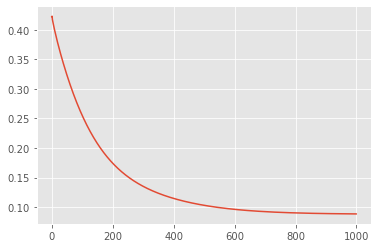

In [4]:
init_dict = {}
init_dict['intercept'] = {
    'type':'walk',
    'weight': np.ones(len(y))*(-0.25)
}
init_dict['Winter Rain'] = {
    'type':'walk',
    'weight': np.ones(len(y))*0.05
}
init_dict['Harvest Rain'] = {
    'type':'scalar',
    'weight': -0.1
}
init_dict['Winter Temperature'] = {
    'type':'scalar',
    'weight': -0.35
}
init_dict['Square Winter Temperature'] = {
    'type':'scalar',
    'weight': -0.35
}
init_dict['Summer Temperature'] = {
    'type':'scalar',
    'weight': 0.5
}
init_dict['Square Summer Temperature'] = {
    'type':'scalar',
    'weight': -0.4
}
init_dict['Harvest Temperature'] = {
    'type':'scalar',
    'weight': 1.6
}
init_dict['Square Harvest Temperature'] = {
    'type':'scalar',
    'weight': -1.6
}
init_dict['Frost Days'] = {
    'type':'walk',
    'weight': np.ones(len(y))*(-0.25)
}
init_dict['Frost Days Prev Fall'] = {
    'type':'walk',
    'weight': np.ones(len(y))*(-0.25)
}

model = Regressive_Model(init_dict, len(y))
optimizer = torch.optim.Adam(model.parameters())

losses = training_loop(model, optimizer)
plt.plot(losses)

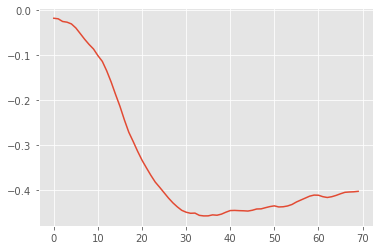

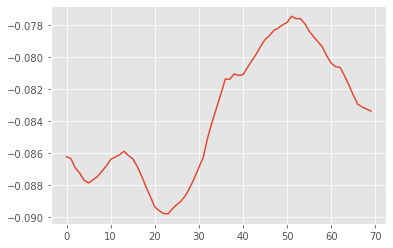

In [5]:
plt.plot(model.intercept.detach().numpy())
plt.show()
plt.plot(model.weights_frost_days_prev_fall.detach().numpy())

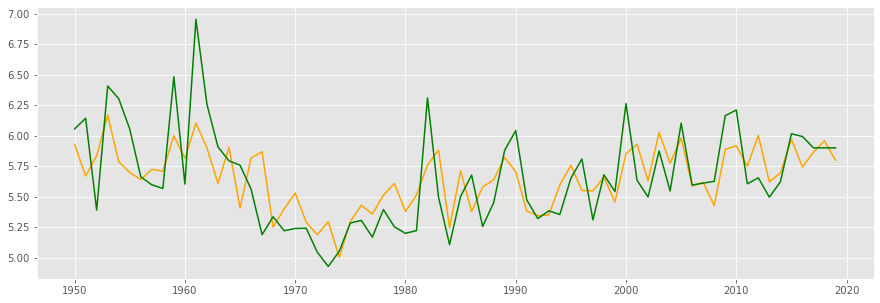

In [6]:
plt.figure(figsize=(15,5))
full_predictions  = model(X_tensor).detach().numpy()
predictions = full_predictions[44:-4]
plt.plot(range(1950, 2020), full_predictions, color='orange')
plt.plot(y['Log Price'], color='g')


# With positive winter temperature

Spearman correlation between results and real log prices: 
 0.6600790513833994
Spearman correlation between results and real log prices / full: 
 0.7332073561432942

R2 between results and real log prices: 
 -0.8644427092256128
R2 between results and real log prices / full: 
 -0.3401487103827696

MAE between results and real log prices: 
 0.175365613101509
MAE between results and real log prices / full: 
 0.21831199332429826


Spearman correlation between results and real log prices: 
 0.6442687747035574
Spearman correlation between results and real log prices / full: 
 0.723094151230973

R2 between results and real log prices: 
 -0.31226360022086075
R2 between results and real log prices / full: 
 -0.2645779879430865

MAE between results and real log prices: 
 0.1731616250109538
MAE between results and real log prices / full: 
 0.2195074312288997


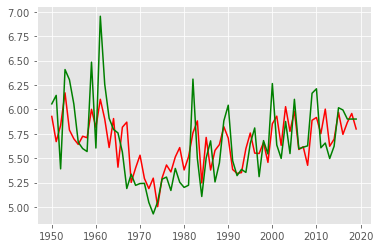

In [7]:
from scipy.stats import spearmanr
from sklearn.metrics import r2_score

plt.plot(range(1950, 2020), full_predictions, color='r')
plt.plot(y['Log Price'], color='g')
print('Spearman correlation between results and real log prices: \n', spearmanr(predictions, y.loc[1994:2015, 'Log Price']).correlation)
print('Spearman correlation between results and real log prices / full: \n', spearmanr(full_predictions, y.loc[1950:2019, 'Log Price']).correlation)

print('\nR2 between results and real log prices: \n', r2_score(predictions, y.loc[1994:2015, 'Log Price']))
print('R2 between results and real log prices / full: \n', r2_score(full_predictions, y['Log Price']))

print('\nMAE between results and real log prices: \n', np.mean(np.abs(predictions - y.loc[1994:2015, 'Log Price'])))
print('MAE between results and real log prices / full: \n', np.mean(np.abs(full_predictions - y['Log Price'])))

# Adaptative model: does not cheat

In [8]:
import torch

class Initial_Model(torch.nn.Module):
    """Optimizes over the whole given dataframe"""
    def __init__(self, init_dict, length):
        super().__init__()
        
        self.weights = {}
        self.init_dict = init_dict
        self.length = length
        self.type = {}
        
        self.weights_intercept = torch.nn.Parameter(torch.from_numpy(init_dict['intercept']['weight']))
        self.weights_winter_rain = torch.nn.Parameter(torch.from_numpy(init_dict['Winter Rain']['weight']))
        self.weights_harvest_rain = torch.nn.Parameter(torch.tensor(init_dict['Harvest Rain']['weight']))
        self.weights_frost_days = torch.nn.Parameter(torch.from_numpy(init_dict['Frost Days']['weight']))
        self.weights_frost_days_prev_fall = torch.nn.Parameter(torch.from_numpy(init_dict['Frost Days Prev Fall']['weight']))

        self.weights_winter_temperature = torch.nn.Parameter(torch.tensor(init_dict['Winter Temperature']['weight']))
        self.weights_square_winter_temperature = torch.nn.Parameter(torch.tensor(init_dict['Square Winter Temperature']['weight']))
        self.weights_summer_temperature = torch.nn.Parameter(torch.tensor(init_dict['Summer Temperature']['weight']))
        self.weights_square_summer_temperature = torch.nn.Parameter(torch.tensor(init_dict['Square Summer Temperature']['weight']))
        self.weights_harvest_temperature = torch.nn.Parameter(torch.tensor(init_dict['Harvest Temperature']['weight']))
        self.weights_square_harvest_temperature = torch.nn.Parameter(torch.tensor(init_dict['Square Harvest Temperature']['weight']))

        self.register_parameter('intercept', self.weights_intercept)
        
        self.register_parameter('Winter Rain', self.weights_winter_rain)
        self.register_parameter('Frost Days', self.weights_frost_days)
        self.register_parameter('Frost Days Prev Fall', self.weights_frost_days_prev_fall)
        self.walk_params = torch.nn.ParameterList([self.weights_winter_rain, self.weights_frost_days, self.weights_frost_days_prev_fall])
        self.where_to_find_walks = [COLUMN_NAMES.index(coeff_name) for coeff_name in ['Winter Rain', 'Frost Days', 'Frost Days Prev Fall']]
        
        self.register_parameter('Harvest Rain', self.weights_harvest_rain)
        self.register_parameter('Winter Temperature', self.weights_winter_temperature)
        self.register_parameter('Square Winter Temperature', self.weights_square_winter_temperature)
        self.register_parameter('Summer Temperature', self.weights_winter_temperature)
        self.register_parameter('Square Summer Temperature', self.weights_square_winter_temperature)
        self.register_parameter('Harvest Temperature', self.weights_winter_temperature)
        self.register_parameter('Square Harvest Temperature', self.weights_square_winter_temperature)
        self.scalar_params = torch.nn.ParameterList(
            [
                self.weights_harvest_rain,
                self.weights_winter_temperature,
                self.weights_square_winter_temperature,
                self.weights_summer_temperature,
                self.weights_square_summer_temperature,
                self.weights_harvest_temperature,
                self.weights_square_harvest_temperature
            ])
        self.where_to_find_scalars = [COLUMN_NAMES.index(coeff_name) for coeff_name in ['Harvest Rain', 'Winter Temperature', 'Square Winter Temperature', 'Summer Temperature', 'Square Summer Temperature', 'Harvest Temperature', 'Square Harvest Temperature']]
        
    def forward(self, X):
        """ 
        Forward pass of the model on one vintage
        """
        result = torch.ones(self.length)*6
        result += self.weights_intercept
        
        for i in range(len(self.walk_params)):
            result += self.walk_params[i] * X[:,self.where_to_find_walks[i]]
            
        for i in range(len(self.scalar_params)):
            result += self.scalar_params[i] * X[:,self.where_to_find_scalars[i]]
        return result
    
    def predict_extra_vintage(self, X):
        """ 
        Predicts the vintage just after the trained range, based on data in X
        """
        result = torch.ones(1)*6
        coefficients = {}
        coefficients['intercept'] = self.weights_intercept[-1]
        result += coefficients['intercept']
        
        for i in range(len(self.walk_params)):
            coeff_name = COLUMN_NAMES[self.where_to_find_walks[i]]
            coefficients[coeff_name] = self.walk_params[i][-1]
            result += coefficients[coeff_name] * X[self.where_to_find_scalars[i]]
            
        for i in range(len(self.scalar_params)):
            coeff_name = COLUMN_NAMES[self.where_to_find_scalars[i]]
            coefficients[coeff_name] = self.scalar_params[i]
            result += coefficients[coeff_name] * X[self.where_to_find_scalars[i]]
        return result, coefficients
    
    def loss_regularize_walk(self):
        loss = 0
        for t in self.walk_params:
            loss += 100*torch.mean((t[1:] - t[:-1])*(t[1:] - t[:-1]))
            
        loss += torch.mean((self.weights_intercept[1:] - self.weights_intercept[:-1])*(self.weights_intercept[1:] - self.weights_intercept[:-1]))
        return loss
            
    #def loss_keep_close_to_prior(self):
    #    loss = 0
    #    for coeff in self.weights.keys():
    #        loss += torch.mean((self.weights[coeff] - self.init_dict[coeff])*(self.weights[coeff] - self.init_dict[coeff]))
    #    
    #    loss += self.weights_intercept
    #    
    #    for i in range(len(walk_params)):
    #        loss += torch.mean((self.weights[coeff] - self.init_dict[coeff])*(self.weights[coeff] - self.init_dict[coeff]))
    #        
    #    for i in range(len(scalar_params)):
    #        loss += self.scalar_params[i] * X[self.scalar_coeff_names[i],:]
    #    return loss
    
    def loss_target(self, X, y):
        return torch.mean((y - self(X))*(y - self(X)))
    
    def combined_loss(self, X, y):
        return self.loss_target(X, y) + 50*self.loss_regularize_walk() #+ self.loss_keep_close_to_prior()

def training_loop(model, optimizer, n=3000):
    "Training loop for torch model."
    losses = []
    for i in range(n):
        loss = model.combined_loss(X_tensor, y_tensor)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.detach().numpy().item())
    return losses

In [9]:
def define_init_dict(len):
    init_dict = {}
    init_dict['intercept'] = {
        'type':'walk',
        'weight': np.ones(len)*(-0.25)
    }
    init_dict['Winter Rain'] = {
        'type':'walk',
        'weight': np.ones(len)*0.05
    }
    init_dict['Harvest Rain'] = {
        'type':'scalar',
        'weight': -0.1
    }
    init_dict['Winter Temperature'] = {
        'type':'scalar',
        'weight': -0.35
    }
    init_dict['Square Winter Temperature'] = {
        'type':'scalar',
        'weight': 0.35
    }
    init_dict['Summer Temperature'] = {
        'type':'scalar',
        'weight': 0.5
    }
    init_dict['Square Summer Temperature'] = {
        'type':'scalar',
        'weight': -0.4
    }
    init_dict['Harvest Temperature'] = {
        'type':'scalar',
        'weight': 1.6
    }
    init_dict['Square Harvest Temperature'] = {
        'type':'scalar',
        'weight': -1.6
    }
    init_dict['Frost Days'] = {
        'type':'walk',
        'weight': np.ones(len)*(-0.25)
    }
    init_dict['Frost Days Prev Fall'] = {
        'type':'walk',
        'weight': np.ones(len)*(-0.25)
    }
    return init_dict

In [10]:
import copy

def extend_tensor(tensor, extension):
    value = tensor.detach().data.clone().numpy()
    new_value = np.zeros(np.size(value)+extension)*copy.deepcopy(value[-1])
    new_value[:-extension] = copy.deepcopy(value)
    return torch.nn.Parameter(torch.from_numpy(new_value))
    
def copy_tensor(tensor):
    return torch.nn.Parameter(copy.deepcopy(tensor.detach().data.clone()), requires_grad=False)
    
class Additional_Model(torch.nn.Module):
    """Optimizes over the previous model's dataframe + one year"""
    def __init__(self, prev_model, length, print_all = False):
        super().__init__()
        
        self.weights = {}
        self.init_dict = init_dict
        self.length = length
        self.extension = self.length - prev_model.length
        self.type = {}
        self.print_all = print_all
        
        # Save init value
        self.register_buffer('init_intercept', prev_model.weights_intercept)
        self.register_buffer('init_winter_rain', prev_model.weights_winter_rain)
        self.register_buffer('init_frost_days', prev_model.weights_frost_days)
        self.register_buffer('init_frost_days_prev_fall', prev_model.weights_frost_days_prev_fall)
        self.init_walk_params = torch.nn.ParameterList([self.init_winter_rain, self.init_frost_days, self.init_frost_days_prev_fall])

        self.register_buffer('init_harvest_rain', prev_model.weights_harvest_rain)
        self.register_buffer('init_winter_temperature', prev_model.weights_winter_temperature)
        self.register_buffer('init_square_winter_temperature', prev_model.weights_square_winter_temperature)
        self.register_buffer('init_summer_temperature', prev_model.weights_summer_temperature)
        self.register_buffer('init_square_summer_temperature', prev_model.weights_square_summer_temperature)
        self.register_buffer('init_harvest_temperature', prev_model.weights_summer_temperature)
        self.register_buffer('init_square_harvest_temperature', prev_model.weights_square_summer_temperature)
        self.init_scalar_params = torch.nn.ParameterList(
            [
                self.init_harvest_rain,
                self.init_winter_temperature,
                self.init_square_winter_temperature,
                self.init_summer_temperature,
                self.init_square_summer_temperature,
                self.init_harvest_temperature,
                self.init_square_harvest_temperature
            ])
        
        self.weights_intercept = extend_tensor(prev_model.weights_intercept, self.extension)
        self.weights_winter_rain = extend_tensor(prev_model.weights_winter_rain, self.extension)
        self.weights_frost_days = extend_tensor(prev_model.weights_frost_days, self.extension)
        self.weights_frost_days_prev_fall = extend_tensor(prev_model.weights_frost_days_prev_fall, self.extension)

        self.weights_harvest_rain = copy_tensor(prev_model.weights_harvest_rain)
        self.weights_winter_temperature = copy_tensor(prev_model.weights_winter_temperature)
        self.weights_square_winter_temperature = copy_tensor(prev_model.weights_square_winter_temperature)
        self.weights_summer_temperature = copy_tensor(prev_model.weights_summer_temperature)
        self.weights_square_summer_temperature = copy_tensor(prev_model.weights_square_summer_temperature)
        self.weights_harvest_temperature = copy_tensor(prev_model.weights_summer_temperature)
        self.weights_square_harvest_temperature = copy_tensor(prev_model.weights_square_summer_temperature)
        
        self.register_parameter('intercept', self.weights_intercept)
        self.register_parameter('Winter Rain', self.weights_winter_rain)
        self.register_parameter('Frost Days', self.weights_frost_days)
        self.register_parameter('Frost Days Prev Fall', self.weights_frost_days_prev_fall)
        self.walk_params = torch.nn.ParameterList([self.weights_winter_rain, self.weights_frost_days, self.weights_frost_days_prev_fall])
        self.where_to_find_walks = [COLUMN_NAMES.index(coeff_name) for coeff_name in ['Winter Rain', 'Frost Days', 'Frost Days Prev Fall']]
        
        self.register_parameter('Harvest Rain', self.weights_harvest_rain)
        self.register_parameter('Winter Temperature', self.weights_winter_temperature)
        self.register_parameter('Square Winter Temperature', self.weights_square_winter_temperature)
        self.register_parameter('Summer Temperature', self.weights_winter_temperature)
        self.register_parameter('Square Summer Temperature', self.weights_square_winter_temperature)
        self.register_parameter('Harvest Temperature', self.weights_winter_temperature)
        self.register_parameter('Square Harvest Temperature', self.weights_square_winter_temperature)
        self.scalar_params = torch.nn.ParameterList(
            [
                self.weights_harvest_rain,
                self.weights_winter_temperature,
                self.weights_square_winter_temperature,
                self.weights_summer_temperature,
                self.weights_square_summer_temperature,
                self.weights_harvest_temperature,
                self.weights_square_harvest_temperature
            ])
        self.where_to_find_scalars = [COLUMN_NAMES.index(coeff_name) for coeff_name in ['Harvest Rain', 'Winter Temperature', 'Square Winter Temperature', 'Summer Temperature', 'Square Summer Temperature', 'Harvest Temperature', 'Square Harvest Temperature']]
        
    def forward(self, X):
        """ 
        Forward pass of the model on one vintage
        """
        result = torch.ones(self.length)*6
        result += self.weights_intercept
        
        for i in range(len(self.walk_params)):
            result += self.walk_params[i] * X[:,self.where_to_find_walks[i]]
            
        for i in range(len(self.scalar_params)):
            result += self.scalar_params[i] * X[:,self.where_to_find_scalars[i]]
        return result
    
    def predict_extra_vintage(self, X):
        """ 
        Predicts the vintage just after the trained range, based on data in X
        """
        result = torch.ones(1)*6
        coefficients = {}
        coefficients['intercept'] = self.weights_intercept[-1]
        result += coefficients['intercept']
        
        for i in range(len(self.walk_params)):
            coeff_name = COLUMN_NAMES[self.where_to_find_walks[i]]
            coefficients[coeff_name] = self.walk_params[i][-1]
            result += coefficients[coeff_name] * X[self.where_to_find_scalars[i]]
            
        for i in range(len(self.scalar_params)):
            coeff_name = COLUMN_NAMES[self.where_to_find_scalars[i]]
            coefficients[coeff_name] = self.scalar_params[i]
            result += coefficients[coeff_name] * X[self.where_to_find_scalars[i]]
        return result, coefficients
    
    def loss_regularize_walk(self):
        loss = 0
        for t in self.walk_params:
            loss += torch.mean((t[1:] - t[:-1])*(t[1:] - t[:-1]))
            loss += torch.mean((t[2:] - t[:-2])*(t[2:] - t[:-2]))
            
        loss += torch.mean((self.weights_intercept[1:] - self.weights_intercept[:-1])*(self.weights_intercept[1:] - self.weights_intercept[:-1]))
        loss += torch.mean((self.weights_intercept[2:] - self.weights_intercept[:-2])*(self.weights_intercept[2:] - self.weights_intercept[:-2]))
        return loss
            
    def loss_keep_close_to_prior(self):
        loss = 0
        loss += 100*torch.mean((self.weights_intercept[:-self.extension] - self.init_intercept)*(self.weights_intercept[:-self.extension] - self.init_intercept))
        
        for i in range(len(self.walk_params)):
            loss += torch.mean((self.walk_params[i][:-self.extension] - self.init_walk_params[i])*(self.walk_params[i][:-self.extension] - self.init_walk_params[i]))
            
        for i in range(len(self.scalar_params)):
            #if self.print_all:
                #print('\n',COLUMN_NAMES[self.where_to_find_scalars[i]])
                #print(self.scalar_params[i])
                #print(self.init_scalar_params[i])
            loss += torch.mean((self.scalar_params[i] -self.init_scalar_params[i])*(self.scalar_params[i] -self.init_scalar_params[i]))
        return loss
    
    
    def loss_target(self, X, y):
        return torch.mean((y - self(X))*(y - self(X)))
    
    def combined_loss(self, X, y):
        return 0*self.loss_target(X, y) + 1000*self.loss_regularize_walk() + 0*self.loss_keep_close_to_prior()

X_tensor = torch.FloatTensor(X.loc[1950 : 1993, :].values)
y_tensor = torch.from_numpy(y.loc[1950 : 1993, 'Log Price'].values)
    
training_length = 1994-1950
vintage_model_1994 = Initial_Model(define_init_dict(training_length), training_length)
optimizer = torch.optim.Adam(vintage_model_1994.parameters())

losses = training_loop(vintage_model_1994, optimizer)

X_tensor = torch.FloatTensor(X.loc[1950 : 1994, :].values)
y_tensor = torch.from_numpy(y.loc[1950 : 1994, 'Log Price'].values)
training_length = 1995-1950
vintage_model_1995 = Additional_Model(vintage_model_1994, training_length)
optimizer = torch.optim.Adam(vintage_model_1995.parameters(), lr=0.1)

losses = training_loop(vintage_model_1995, optimizer)

In [11]:
from tqdm import tqdm
predictions = []
coefficients_record = {}
plot=True

X_tensor = torch.FloatTensor(X.loc[1950 : 1993, :].values)
y_tensor = torch.from_numpy(y.loc[1950 : 1993, 'Log Price'].values)
    
training_length = 1994-1950
vintage_model_1994 = Initial_Model(define_init_dict(training_length), training_length)
optimizer = torch.optim.Adam(vintage_model_1994.parameters())
losses = training_loop(vintage_model_1994, optimizer)

result_tuple = vintage_model_1994.predict_extra_vintage(torch.FloatTensor(X.loc[1994, :].values))
prediction, coefficients  = result_tuple[0].detach().numpy()[0], result_tuple[1]
print(prediction)
predictions.append(prediction)
    
for coeff in list(define_init_dict(0).keys()):
    coefficients_record[coeff] = [coefficients[coeff].detach().numpy()]
        
vintage_models = [vintage_model_1994]
for param in vintage_model_1994.parameters():
    param.requires_grad = False
    
for vintage in tqdm(range(1995, 2016)):
    X_tensor = torch.FloatTensor(X.loc[1950 : vintage-1, :].values)
    y_tensor = torch.from_numpy(y.loc[1950 : vintage-1, 'Log Price'].values)
    training_length = vintage-1950
    
    if vintage==1995:
        last_model = Additional_Model(vintage_model_1994, training_length, print_all=True)
    else:
        last_model = Additional_Model(vintage_model_1994, training_length)
        
    optimizer2 = torch.optim.Adam(last_model.parameters(), lr=0.6)
    training_loop(last_model, optimizer2)
    last_model.zero_grad()
    
    result_tuple = last_model.predict_extra_vintage(torch.FloatTensor(X.loc[vintage, :].values))
    prediction, coefficients  = result_tuple[0].detach().numpy()[0], result_tuple[1]
    print(prediction)
    predictions.append(prediction)
    vintage_models.append(last_model)
    
    for coeff in list(define_init_dict(0).keys()):
        coefficients_record[coeff].append(coefficients[coeff].detach().numpy())

  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

5.534109


  5%|███▉                                                                               | 1/21 [00:18<06:11, 18.56s/it]

5.970775


 10%|███████▉                                                                           | 2/21 [00:37<05:55, 18.72s/it]

5.880963


 14%|███████████▊                                                                       | 3/21 [00:57<05:44, 19.14s/it]

5.9953523


 19%|███████████████▊                                                                   | 4/21 [01:17<05:26, 19.21s/it]

5.9755044


 24%|███████████████████▊                                                               | 5/21 [01:37<05:11, 19.46s/it]

6.000394


 29%|███████████████████████▋                                                           | 6/21 [01:55<04:46, 19.12s/it]

5.9044385


 33%|███████████████████████████▋                                                       | 7/21 [02:15<04:29, 19.24s/it]

5.8684773


 38%|███████████████████████████████▌                                                   | 8/21 [02:35<04:13, 19.49s/it]

5.8066792


 43%|███████████████████████████████████▌                                               | 9/21 [02:54<03:53, 19.46s/it]

5.9587455


 48%|███████████████████████████████████████                                           | 10/21 [03:14<03:35, 19.56s/it]

5.9544363


 52%|██████████████████████████████████████████▉                                       | 11/21 [03:33<03:15, 19.51s/it]

5.9362597


 57%|██████████████████████████████████████████████▊                                   | 12/21 [03:53<02:55, 19.46s/it]

6.062192


 62%|██████████████████████████████████████████████████▊                               | 13/21 [04:11<02:32, 19.02s/it]

5.814378


 67%|██████████████████████████████████████████████████████▋                           | 14/21 [04:31<02:16, 19.45s/it]

5.774063


 71%|██████████████████████████████████████████████████████████▌                       | 15/21 [04:51<01:57, 19.57s/it]

5.94454


 76%|██████████████████████████████████████████████████████████████▍                   | 16/21 [05:11<01:39, 19.81s/it]

5.7864146


 81%|██████████████████████████████████████████████████████████████████▍               | 17/21 [05:31<01:19, 19.92s/it]

5.8632407


 86%|██████████████████████████████████████████████████████████████████████▎           | 18/21 [05:51<00:59, 19.85s/it]

5.8706903


 90%|██████████████████████████████████████████████████████████████████████████▏       | 19/21 [06:12<00:40, 20.09s/it]

5.877429


 95%|██████████████████████████████████████████████████████████████████████████████    | 20/21 [06:32<00:20, 20.01s/it]

6.0292044


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [06:52<00:00, 19.63s/it]

5.8224726


[5.534109, 5.970775, 5.880963, 5.9953523, 5.9755044, 6.000394, 5.9044385, 5.8684773, 5.8066792, 5.9587455, 5.9544363, 5.9362597, 6.062192, 5.814378, 5.774063, 5.94454, 5.7864146, 5.8632407, 5.8706903, 5.877429, 6.0292044, 5.8224726]
Spearman correlation between results and real log prices: 
 -0.047995482778091486

R2 between results and real log prices: 
 -7.715873034126794

MAE between results and real log prices: 
 0.29462681893922193


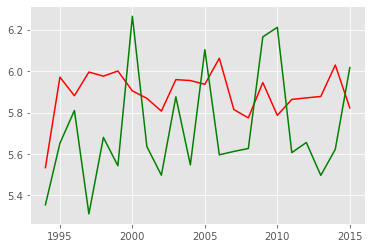

In [12]:
plt.plot(range(1994, 2016), predictions, color='r')
plt.plot(y.loc[1994:2015, 'Log Price'], color='g')
print(predictions)
print('Spearman correlation between results and real log prices: \n', spearmanr(predictions, y.loc[1994:2015, 'Log Price']).correlation)
print('\nR2 between results and real log prices: \n', r2_score(predictions, y.loc[1994:2015, 'Log Price']))
print('\nMAE between results and real log prices: \n', np.mean(np.abs(predictions - y.loc[1994:2015, 'Log Price'])))

dict_keys(['intercept', 'Winter Rain', 'Harvest Rain', 'Winter Temperature', 'Square Winter Temperature', 'Summer Temperature', 'Square Summer Temperature', 'Harvest Temperature', 'Square Harvest Temperature', 'Frost Days', 'Frost Days Prev Fall'])


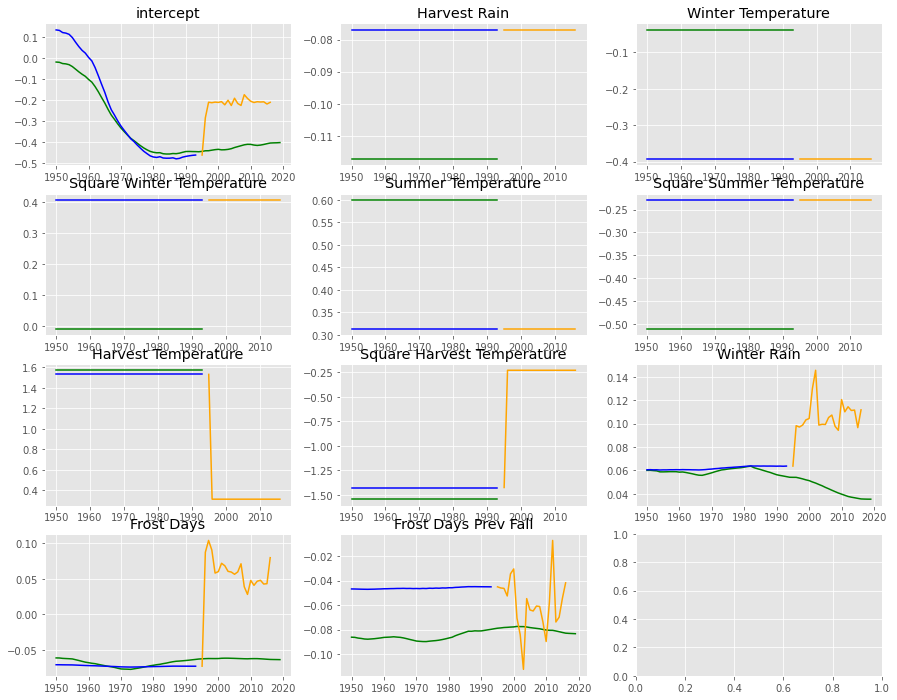

In [13]:
plt.rcParams['figure.figsize']= [15, 12]

fig, axs = plt.subplots(4,3)
print(coefficients_record.keys())
subplot = axs[0, 0]
coeff = 'intercept'
subplot.plot(range(1950, 2020), model.weights_intercept.detach().numpy(), color='green')
subplot.plot(range(1950, 1994), vintage_model_1994.weights_intercept.detach().numpy(), color='blue')

subplot.plot(range(1995, 2017), coefficients_record[coeff], color='orange')
subplot.set_title('intercept')
    
for i in range(len(vintage_model_1994.scalar_params)):
    n = i+1
    subplot = axs[n//3, n%3]
    coeff = COLUMN_NAMES[vintage_model_1994.where_to_find_scalars[i]]
    subplot.plot(range(1950, 1994), [model.scalar_params[i]]*44, color='green')
    subplot.plot(range(1950, 1994), [vintage_model_1994.scalar_params[i]]*44, color='blue')

    subplot.plot(range(1995, 2017), coefficients_record[coeff], color='orange')
    subplot.set_title(COLUMN_NAMES[vintage_model_1994.where_to_find_scalars[i]])

    
for i in range(len(vintage_model_1994.walk_params)):
    n = len(vintage_model_1994.scalar_params) + i+1
    subplot = axs[n//3, n%3]
    coeff = COLUMN_NAMES[vintage_model_1994.where_to_find_walks[i]]

    subplot.plot(range(1950, 2020), model.walk_params[i].detach().numpy(), color='green')
    subplot.plot(range(1950, 1994), vintage_model_1994.walk_params[i].detach().numpy(), color='blue')

    subplot.plot(range(1995, 2017), coefficients_record[coeff], color='orange')
    subplot.set_title(COLUMN_NAMES[vintage_model_1994.where_to_find_walks[i]])



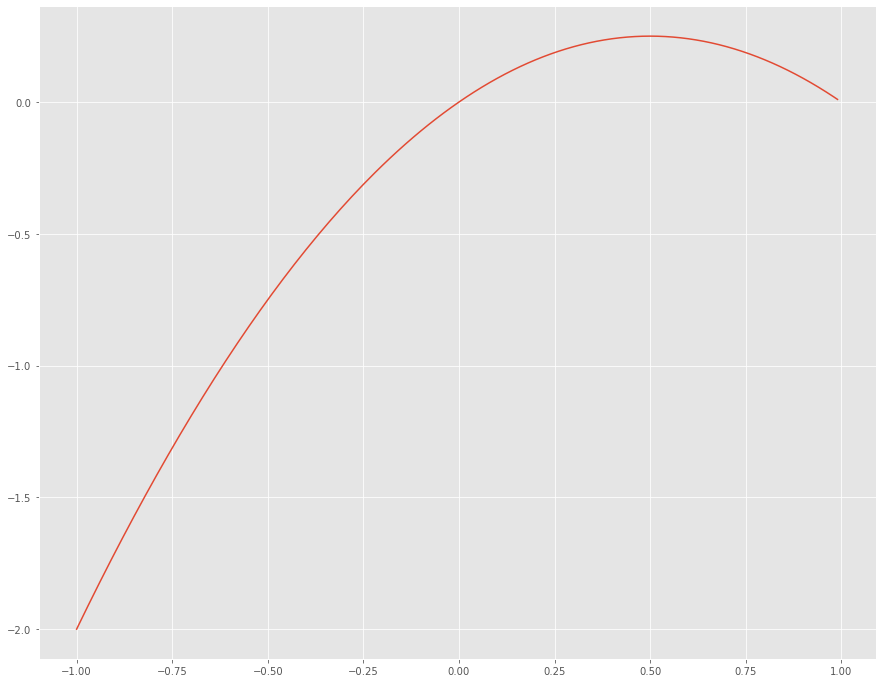

In [86]:
X = np.arange(-1, 1, 0.01)
Y = X - X*X

plt.plot(X,Y)